In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
bezirke = [
    'charlottenburg-wilmersdorf',
    'friedrichshain-kreuzberg',
    'lichtenberg',
    'marzahn-hellersdorf',
    'mitte',
    'neukoelln',
    'pankow',
    'reinickendorf',
    'spandau',
    'steglitz-zehlendorf',
    'tempelhof-schoeneberg',
    'treptow-koepenick'
]
years = [2013, 2014, 2015, 2016]
data_path = '../data/raw/'

dfs = []
for year in years:
    for bezirk in bezirke:
        df = pd.read_csv( data_path + str(year) +'-'+ bezirk + '.csv', sep=';')
        df = df.dropna()
        df = df.assign(Bezirk=bezirk.title(), Year=year)
        total_number_names = df['anzahl'].sum()
        df = df.assign(frequency = lambda df: df['anzahl']/total_number_names )
        #df_m = df[df['geschlecht']=='m']
        #print(df_m[ df_m['frequency'] == df_m['frequency'].max() ]['vorname'])
        dfs.append(df)
        
df = pd.concat(dfs)
#df = df.sort_values('anzahl', ascending=False )

In [3]:
df.head()

,Bezirk,Year,anzahl,frequency,geschlecht,vorname
0,Charlottenburg-Wilmersdorf,2013,121,0.013668,w,Marie
1,Charlottenburg-Wilmersdorf,2013,96,0.010844,w,Sophie
2,Charlottenburg-Wilmersdorf,2013,77,0.008698,w,Charlotte
3,Charlottenburg-Wilmersdorf,2013,66,0.007455,w,Emilia
4,Charlottenburg-Wilmersdorf,2013,64,0.007229,m,Paul


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109988 entries, 0 to 1127
Data columns (total 6 columns):
Bezirk        109988 non-null object
Year          109988 non-null int64
anzahl        109988 non-null int64
frequency     109988 non-null float64
geschlecht    109988 non-null object
vorname       109988 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 5.9+ MB


In [5]:
df[ (df['Year']==2015) & (df['Bezirk']=='Mitte')  ]['frequency'].sum()

1.0000000000000002

In [6]:
df.max()

Bezirk        Treptow-Koepenick
Year                       2016
anzahl                      128
frequency             0.0169067
geschlecht                    w
vorname                    Ọňum
dtype: object

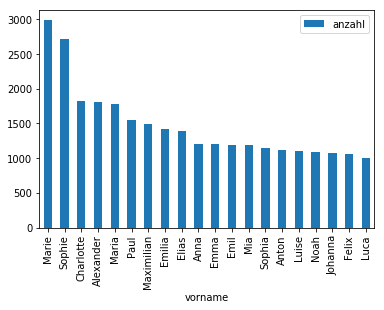

In [11]:
dfgroup = df[['Year','vorname','anzahl']].groupby(by=['vorname']).sum()
dfgroup = dfgroup.sort_values('anzahl', ascending=False)
#dfgroup.assign(name = dfgroup.index)
#plt.bar(dfgroup[0:10].index, dfgroup['anzahl'][0:10])
dfgroup[0:20].plot.bar(y='anzahl')
#dfgroup.index
#for vorname in dfgroup['vorname'].unique():
#    nameseries = dfgroup[dfgroup['vorname'] == vorname]
#    plt.plot(nameseries['Year'], nameseries['anzahl'], label=vorname )

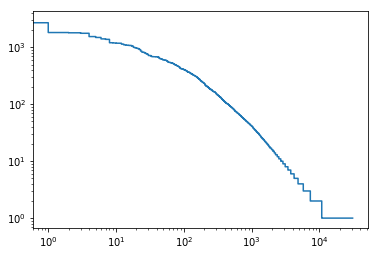

In [82]:
plt.step(x=range(len(dfgroup)),y=dfgroup[ dfgroup['anzahl']>0]['anzahl'])
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

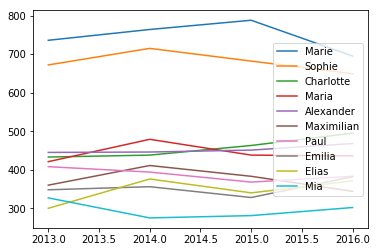

In [66]:
dfgroup2 = df[['Year', 'vorname', 'anzahl']].groupby(by=['vorname', 'Year']).sum()
#dfgroup2 = df[['Year', 'vorname', 'anzahl']].groupby(['vorname', 'Year']).sum().groupby('Year')

#dfgroup2.reset_index()
dfgroup2 = dfgroup2.sort_values('anzahl', ascending=False)
best_names = dfgroup2.index.get_level_values('vorname').unique()[0:10]
#years = dfgroup2.index.get_level_values('Year').unique()
#dfgroup2.iloc[ dfgroup2.index['Year']==2015 ]

#dfgroup2.loc['Marie'].sort_index()
for name in best_names:
    #dfgroup2.loc[name].sort_index().plot.line() 
    plt.plot(dfgroup2.loc[name].sort_index(), label=name)
plt.legend(loc='right')
#dfgroup2.iloc[dfgroup2.index.get_level_values('Year') == 2015]

In [8]:
dfgroup.head()

,Year,anzahl
vorname,,
Marie,114823,2983
Sophie,96696,2718
Charlotte,96696,1829
Alexander,102742,1810
Maria,163172,1774


In [9]:
dfgroup = df.groupby(by=['Year', 'Bezirk', 'vorname']).sum()
dfgroup.head(10)

anzahl  frequency
Year Bezirk                     vorname                        
2013 Charlottenburg-Wilmersdorf Aaron             18   0.002033
                                Aarun              1   0.000113
                                Aba                1   0.000113
                                Abbas              1   0.000113
                                Abd                1   0.000113
                                Abdalaziz          1   0.000113
                                Abdallah           1   0.000113
                                Abdoul-Hamid       1   0.000113
                                Abdullah           4   0.000452
                                Abdullrazak        1   0.000113